In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd.variable import Variable
import torch.optim as optim
import math

from sklearn.model_selection import train_test_split

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import math 
import json as js

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
  cuda = True
  print('Using: ' +str(torch.cuda.get_device_name(device)))
else:
  cuda = False
  print('Using: CPU')

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Using: CPU


In [3]:
def get_rms(records):
    return math.sqrt(sum([x ** 2 for x in records]) / len(records))

In [4]:
peaks = torch.load('./train_peaks.pt')

In [5]:
clean_data = torch.load('./clean_train_data_2dB.pt')
noisy_data = torch.load('./noisy_train_data_2dB.pt')

## For leave one out train/test split

In [6]:
clean_train_data = clean_data[:109000]
noisy_train_data = noisy_data[:109000]
peaks_train = peaks[:109000]

clean_test_data = clean_data[109000:136000]
noisy_test_data = noisy_data[109000:136000]
peaks_test = peaks[109000:136000]

batch_size=20

######## Training_Set ###########
#
# Padd the arrays to max length of peaks
#
#################################
max_length = max(len(row) for row in peaks_train)
x_result = np.array([np.pad(row, (0, max_length-len(row))) for row in peaks_train])
# Create Training dataset with peaks
_data = []
for i in range(len(clean_train_data)):
    _data.append([clean_train_data[i], x_result[i]])
    
# preparing trainLoaders 
arr_trainloader = torch.utils.data.DataLoader(_data, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
nst_trainloader = torch.utils.data.DataLoader(noisy_train_data, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

######## Test_Set ###############
#
# Padd the arrays to max length of peaks
#
#################################
max_length = max(len(row) for row in peaks_test)
x_result = np.array([np.pad(row, (0, max_length-len(row))) for row in peaks_test])
# Create Testing dataset with peaks
_data = []
for i in range(len(clean_test_data)):
    _data.append([clean_test_data[i], x_result[i]])
    
# preparing trainLoaders 
arr_testloader = torch.utils.data.DataLoader(_data, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
nst_testloader = torch.utils.data.DataLoader(noisy_test_data, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
print(len(arr_trainloader), len(arr_testloader))

5450 1350


### For Normal 80/20 train/test split

In [7]:
clean_data = clean_data[:136000]
noisy_data = noisy_data[:136000]
peaks = peaks[:136000]
batch_size=20
# Padd the arrays to max length of peaks
max_length = max(len(row) for row in peaks)
x_result = np.array([np.pad(row, (0, max_length-len(row))) for row in peaks])

# Create Training dataset with peaks
_data = []
for i in range(len(clean_data)):
    _data.append([clean_data[i], x_result[i]])


# preparing training dataset and testing dataset
arr_train, arr_test = train_test_split(_data, test_size = 0.2, random_state=42, shuffle=False)
nst_train, nst_test = train_test_split(noisy_data, test_size = 0.2, random_state=42, shuffle=False)

del _data, noisy_data, clean_data

# preparing trainLoaders 
arr_trainloader = torch.utils.data.DataLoader(arr_train, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

nst_trainloader = torch.utils.data.DataLoader(nst_train, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


# preparing testLoaders 
arr_testloader = torch.utils.data.DataLoader(arr_test, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

nst_testloader = torch.utils.data.DataLoader(nst_test, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print(len(arr_trainloader), len(arr_testloader))

5440 1360


In [4]:
class RCNN(nn.Module):
    def __init__(self, input_size):
        super(RCNN, self).__init__()
    
        self.input_size = input_size

        self.cv1_k = 3
        self.cv1_s = 1
        self.cv1_out = int(((self.input_size - self.cv1_k)/self.cv1_s) + 1)

        self.cv2_k = 3
        self.cv2_s = 1
        self.cv2_out = int(((self.cv1_out - self.cv2_k)/self.cv2_s) + 1)

        self.cv3_k = 5
        self.cv3_s = 1
        self.cv3_out = int(((self.cv2_out - self.cv3_k)/self.cv3_s) + 1)

        self.cv4_k = 5
        self.cv4_s = 1
        self.cv4_out = int(((self.cv3_out - self.cv4_k)/self.cv4_s) + 1)
    
    
        self.layer_1 = nn.Sequential(
          nn.Conv1d(in_channels=1, out_channels=3, kernel_size=(3)),
          nn.BatchNorm1d(num_features=3),
          nn.ReLU(inplace=True),
          nn.AvgPool1d(kernel_size=1)
        )

        self.layer_2 = nn.Sequential(
          nn.Conv1d(in_channels=3, out_channels=5, kernel_size=(3)),
          nn.BatchNorm1d(num_features=5),
          nn.ReLU(inplace=True),
          nn.AvgPool1d(kernel_size=1)
        )

        self.layer_3 = nn.Sequential(
          nn.Conv1d(in_channels=5, out_channels=3, kernel_size=(5)),
          nn.BatchNorm1d(num_features=3),
          nn.ReLU(inplace=True)
        )

        self.layer_4 = nn.Sequential(
          nn.Conv1d(in_channels=3, out_channels=1, kernel_size=(5)),
          nn.BatchNorm1d(num_features=1),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.5, inplace=False)
        )

        self.layer_5 = nn.Sequential(
          nn.Linear(self.cv4_out, 1080), # FC Layer
          nn.Linear(1080, 1080) # Regression
        )
        
    def forward(self, x):
        x = self.layer_1(x) 
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = x.view(x.size(0), -1)
        x = self.layer_5(x)
    
        return x

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, 3, padding='same')
        self.conv2 = nn.Conv1d(16, 8, 3, padding='same')
        self.conv3 = nn.Conv1d(8, 1, 3, padding='same')
        self.conv4 = nn.Conv1d(1, 1, 1080, padding='same')
        self.acti = nn.ReLU()
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = (self.conv1(x))
        x = (self.acti(x))
        x = (self.conv2(x))
        x = (self.acti(x))
        x = (self.conv3(x))
        x = (self.acti(x))
        x = (self.conv4(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        out = self.out(x)
        return out

In [10]:
def lossfcn(y_true, y_pred, peaks, a=20):
  criterion = nn.MSELoss().to(device)
  alpha = a
  loss = 0.0
  R = 0.0
  for x,y,z in zip(y_pred, y_true, peaks):
    qrs_loss = []

    # Remove Padding from NN
    z = z[z.nonzero()]
    for qrs in z:
      max_ind = qrs+1

      if max_ind<35:
        qrs_loss.append(criterion(x[:max_ind+37],
                                  y[:max_ind+37]))
      elif max_ind>1243:
        qrs_loss.append(criterion(x[max_ind-36:],
                                  y[max_ind-36:]))
      else:
        qrs_loss.append(criterion(x[max_ind-36:max_ind+37],
                                  y[max_ind-36:max_ind+37]))
        
    R_loss = alpha*(torch.mean(torch.tensor(qrs_loss))) 
    if math.isnan(R_loss):
      R_loss = 0
    R += R_loss

  loss = criterion(y_true, y_pred) + torch.mean(torch.tensor(R))
  return loss

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
net = CNN().float().to(device) # 1562
#net = RCNN(1080).float().to(device) # 2322180
criterion = nn.MSELoss().to(device) #
optimizer = optim.RMSprop(net.parameters(), lr=0.0002)

In [10]:
count_parameters(net)

1562

In [12]:
for epoch in range(10):  # loop over the dataset multiple times
    print("=========== EPOCH " +str(epoch)+" ===========")
    i = 0
    running_loss = 0.0

    for arr, nst in zip(arr_trainloader, nst_trainloader):
        i += 1
        labels, peaks = arr
        inputs = nst

        # zero the parameter gradients
        optimizer.zero_grad()
        inputs = inputs[:,None,:]
        # forward + backward + optimize
        outputs = net(inputs.float().to(device))
        loss = criterion(outputs, labels.float().to(device))
        #loss = lossfcn(outputs, labels.float().to(device), peaks, a=20)


        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

=========== EPOCH 0 ===========
[1,  1000] loss: 0.024
[1,  2000] loss: 0.008
[1,  3000] loss: 0.005
[1,  4000] loss: 0.003
[1,  5000] loss: 0.003
=========== EPOCH 1 ===========
[2,  1000] loss: 0.002
[2,  2000] loss: 0.003
[2,  3000] loss: 0.002
[2,  4000] loss: 0.002
[2,  5000] loss: 0.001
=========== EPOCH 2 ===========
[3,  1000] loss: 0.001
[3,  2000] loss: 0.002
[3,  3000] loss: 0.001
[3,  4000] loss: 0.001
[3,  5000] loss: 0.001
=========== EPOCH 3 ===========
[4,  1000] loss: 0.001
[4,  2000] loss: 0.002
[4,  3000] loss: 0.001
[4,  4000] loss: 0.001
[4,  5000] loss: 0.001
=========== EPOCH 4 ===========
[5,  1000] loss: 0.001
[5,  2000] loss: 0.002
[5,  3000] loss: 0.001
[5,  4000] loss: 0.001
[5,  5000] loss: 0.001
=========== EPOCH 5 ===========
[6,  1000] loss: 0.001
[6,  2000] loss: 0.002
[6,  3000] loss: 0.001
[6,  4000] loss: 0.001
[6,  5000] loss: 0.001
=========== EPOCH 6 ===========
[7,  1000] loss: 0.001
[7,  2000] loss: 0.002
[7,  3000] loss: 0.001
[7,  4000] loss: 

In [13]:
y, l1 = next(iter(arr_testloader))
x = iter(nst_testloader).next()
x = x.to(device)
outputs = net(x[:,None,:].float())
print(outputs.shape)

torch.Size([20, 1080])


In [15]:
torch.save(net.state_dict(), './2dB_LOO_a0.pt')

## Results from 6dB, RCNN, with no Custom loss LOO split

tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward>)


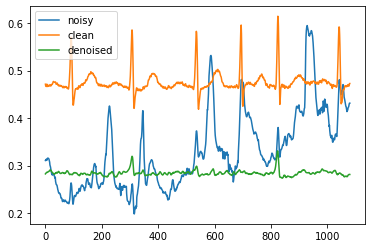

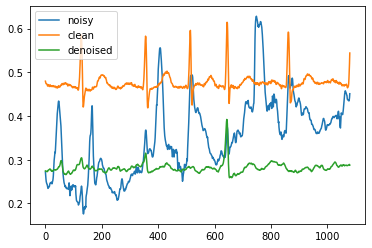

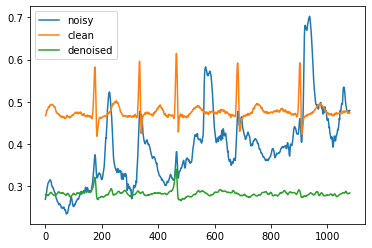

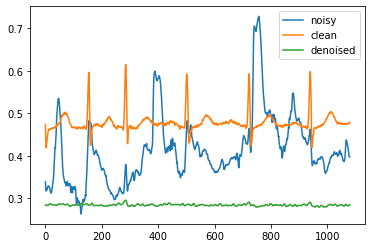

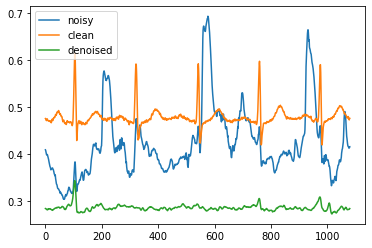

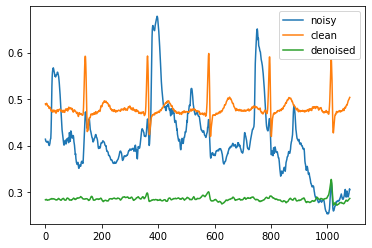

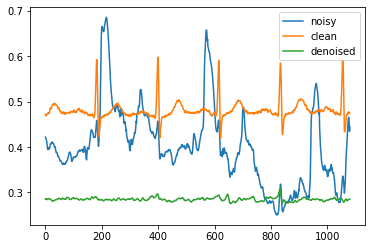

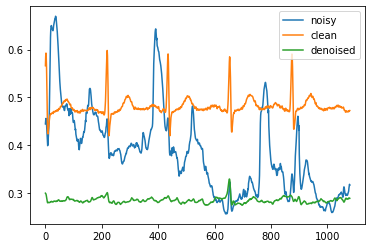

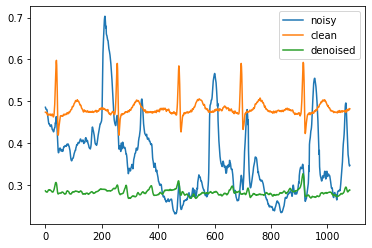

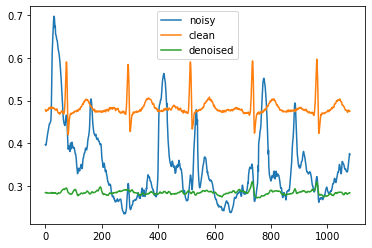

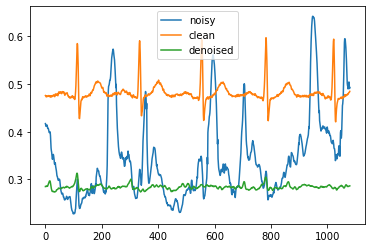

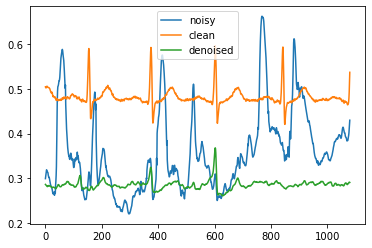

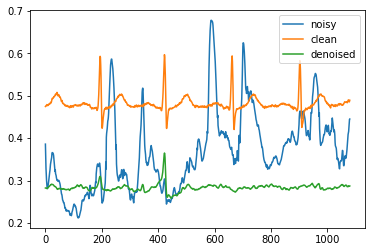

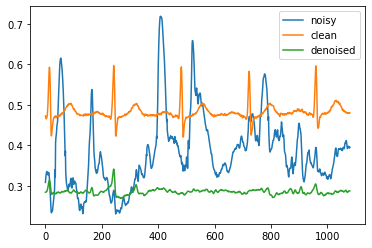

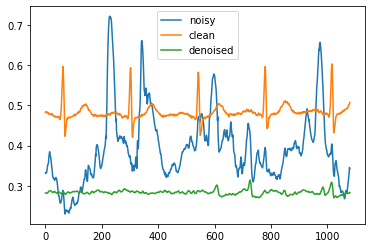

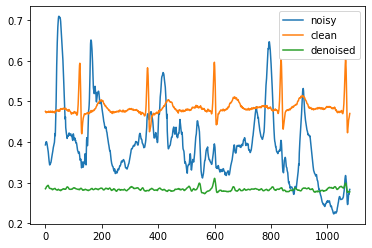

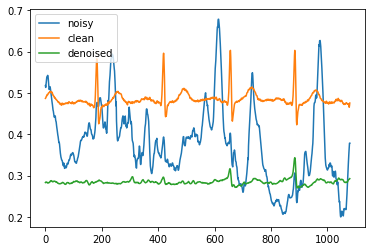

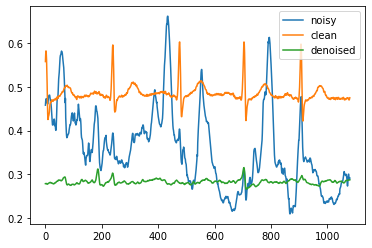

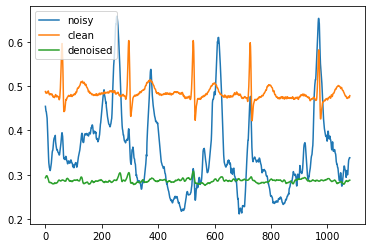

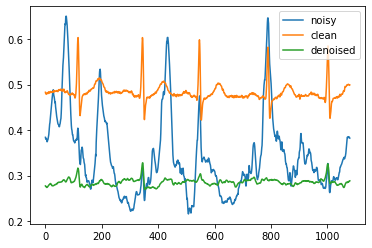

In [16]:
for i in range(len(x)):
  plt.figure()
  plt.plot(x[i].detach().cpu().numpy(), label='noisy')
  plt.plot(y[i].detach().cpu().numpy(), label='clean')
  plt.plot(outputs[i].detach().cpu().numpy()-0.2, label='denoised')
  plt.legend()
print(criterion(outputs, x.float()))

## Results from 6dB, RCNN, with Custom loss LOO split, alpha=2

In [ ]:
for i in range(len(x)):
  plt.figure()
  plt.plot(x[i].detach().cpu().numpy(), label='noisy')
  plt.plot(y[i].detach().cpu().numpy(), label='clean')
  plt.plot(outputs[i].detach().cpu().numpy()-0.2, label='denoised')
  plt.legend()
print(criterion(outputs, x.float()))

## Results from 6dB, RCNN, with Custom loss std train/test split, alpha=5

In [ ]:
for i in range(len(x)):
  plt.figure()
  plt.plot(x[i].detach().cpu().numpy(), label='noisy')
  plt.plot(y[i].detach().cpu().numpy(), label='clean')
  plt.plot(outputs[i].detach().cpu().numpy()-0.2, label='denoised')
  plt.legend()
print(criterion(outputs, x.float()))

## Results from 6dB, RCNN, with Custom loss std train/test split, alpha=20

In [ ]:
for i in range(len(x)):
  plt.figure()
  plt.plot(x[i].detach().cpu().numpy(), label='noisy')
  plt.plot(y[i].detach().cpu().numpy(), label='clean')
  plt.plot(outputs[i].detach().cpu().numpy()-0.2, label='denoised')
  plt.legend()
print(criterion(outputs, x.float()))

## Results from 6dB, RCNN, with Custom loss LOO, alpha=50

In [ ]:
for i in range(len(x)):
  plt.figure()
  plt.plot(x[i].detach().cpu().numpy(), label='noisy')
  plt.plot(y[i].detach().cpu().numpy(), label='clean')
  plt.plot(outputs[i].detach().cpu().numpy(), label='denoised')
  plt.legend()
print(criterion(outputs, x.float()))

## Results from 24dB, CNN, without Custom loss and then with Custom loss, alpha=5

In [ ]:
for i in range(len(x)):
  plt.figure()
  plt.plot(x[i].detach().cpu().numpy(), label='noisy')
  plt.plot(y[i].detach().cpu().numpy(), label='clean')
  plt.plot(outputs[i].detach().cpu().numpy()-0.2, label='denoised')
  plt.legend()
print(criterion(outputs, x.float()))

In [ ]:
for i in range(len(x)):
  plt.figure()
  plt.plot(x[i].detach().cpu().numpy(), label='noisy')
  plt.plot(y[i].detach().cpu().numpy(), label='clean')
  plt.plot(outputs[i].detach().cpu().numpy()-0.2, label='denoised')
  plt.legend()
print(criterion(outputs, x.float()))

In [35]:
print(net)

RCNN(
  (layer_1): Sequential(
    (0): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
  )
  (layer_2): Sequential(
    (0): Conv1d(3, 5, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
  )
  (layer_3): Sequential(
    (0): Conv1d(5, 3, kernel_size=(5,), stride=(1,))
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer_4): Sequential(
    (0): Conv1d(3, 1, kernel_size=(5,), stride=(1,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer_5): Sequential(
    (0): L

In [36]:
print(len(arr_trainloader), len(arr_testloader))

5450 1350


In [37]:
torch.save(net.state_dict(), './24dB_LOO_a2.pt')